In [1]:
import os
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 152.9 MB 27 kB/s 
     |████████████████████████████████| 57 kB 3.0 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.307 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [3]:
!rm -rf bert
!git clone https://github.com/google-research/bert

import sys

sys.path.append('bert/')

import codecs
import collections
import json
import re
import os
import pprint
import numpy as np
import tensorflow as tf
import modeling
import tokenization
import numpy as np
import pandas as pd
import re, string, unicodedata
import os
from os import path

#Visualization Libs
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP Libs
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Additional Libs
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

# Deep Learning Libs
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout


Cloning into 'bert'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 328.28 KiB | 4.26 MiB/s, done.
Resolving deltas: 100% (182/182), done.


In [ ]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

In [5]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.6 MB/s 
     |████████████████████████████████| 596 kB 35.7 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 6.6 MB 36.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/fake_or_real_news.csv')

Mounted at /content/gdrive


In [8]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [9]:
df = df[['title','text','label']]
null_df = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False) * 100

null_df = pd.concat([null_df, percent], axis = 1, keys = ['Counts', '% Missing'])
null_df.head()

,Counts,% Missing
title,0,0.0
text,0,0.0
label,0,0.0


In [10]:
true = df[df['label'] == 'REAL'][:2000]
fake = df[df['label'] == 'FAKE'][:2000]

true.head()

,title,text,label
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
7,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [11]:
true.shape, fake.shape # relative same size good for training model

((2000, 3), (2000, 3))

In [12]:
true['label'] = 1
fake['label'] = 0

df = pd.concat([true, fake],ignore_index= True).drop_duplicates()
df.sample(10)

,title,text,label
394,Obama: U.S. cannot solve the world's problems ...,President Obama told the United Nations on Mon...,1
1727,How Asia trade deal could make or break Obama'...,Hanging in the balance is Obama’s vision of Am...,1
2494,"Police Family Fakes Robbery, Vandalizes Own Ho...",Home / Badge Abuse / Police Family Fakes Robbe...,0
2277,Georgia Abandons Ukraine's Anti-Russian Obsess...,Your daily reality snack Georgia Abandons Ukra...,0
2631,Western “Culture” is Wrecking Entire Continents,Itinerant Philosopher and Journalist Y ou say ...,0
1150,Hillary Clinton to turn over private email ser...,Washington (CNN) Hillary Clinton agreed to tur...,1
3224,"HUGE Air Drill, Over 130 Command Centers in Ru...","HUGE Air Drill, Over 130 Command Centers in Ru...",0
341,Fact checking the fourth round of GOP debates,Fox Business News aired two GOP presidential d...,1
582,Netanyahu walks back Palestinian state comment,(CNN) President Barack Obama told Israeli Prim...,1
2032,Comment on Quid Pro Quo? Wikileaks Email Revea...,New Wikileaks email dumps have revealed massiv...,0


In [13]:
df['text'] = df['title'] + "" + df['text']
# delete the columns we do not need for the rest of the work
# del df['column name']
del df['title']

In [14]:

nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
def strip_html(text):
  # get a BeautifulSoup object that follows standard structure
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text() # extract all the text from a page

# removing the square brackets
def remove_between_square_brackets(text):
  # '' replace patterns occured in left of text like \[[^]*\]
  return re.sub(r'[[^]*\]', '', text)

# removing URL's
def remove_urls(text):
  return re.sub(r'http\S+', '', text)

# removing the stopwords from text
def remove_stopwords(text):
  final_text = []
  for i in text.split():
    if i.strip().lower() not in stop:
      final_text.append(i.strip()) # strip(None) remove blank char in default
  return " ".join(final_text)
  
# removing the noisy text
def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  text = remove_stopwords(text)
  return text

# Apply function on review column
df['text'] = df['text'].apply(denoise_text)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Possible nested set at position 1
  if __name__ == '__main__':


,text,label
0,Kerry go Paris gesture sympathyU.S. Secretary ...,1
1,Battle New York: Primary MattersIt's primary d...,1
2,‘Britain’s Schindler’ Dies 106A Czech stockbro...,1
3,Fact check: Trump Clinton 'commander-in-chief'...,1
4,Iran reportedly makes new push uranium concess...,1


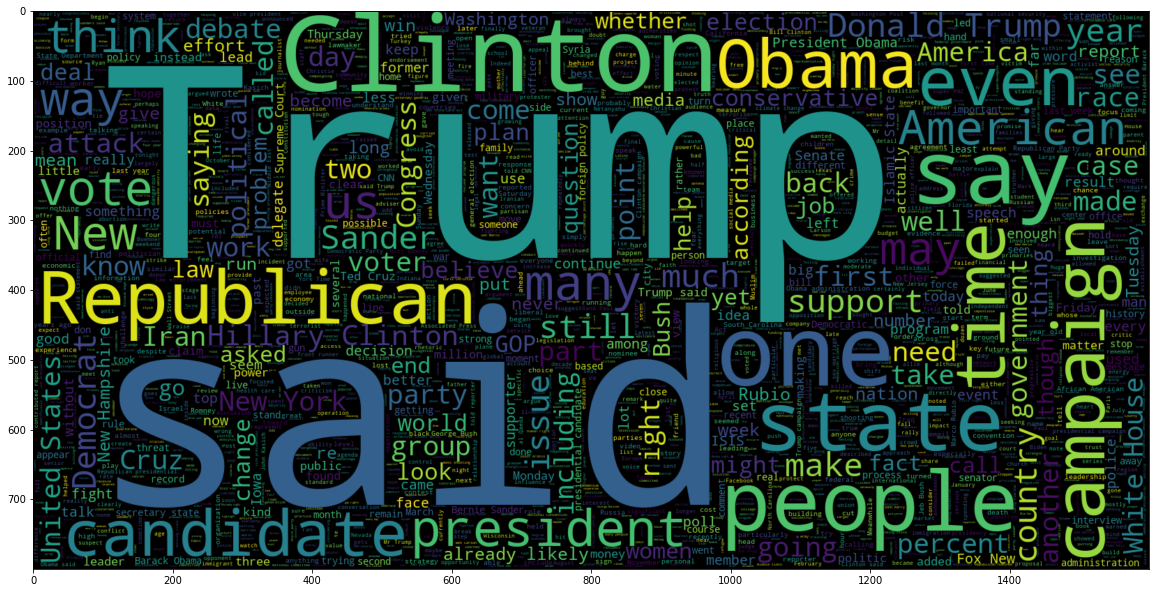

In [16]:
# word clouds for true news
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc, interpolation = 'bilinear')
# show the most prominent or frequent words in a body of true news


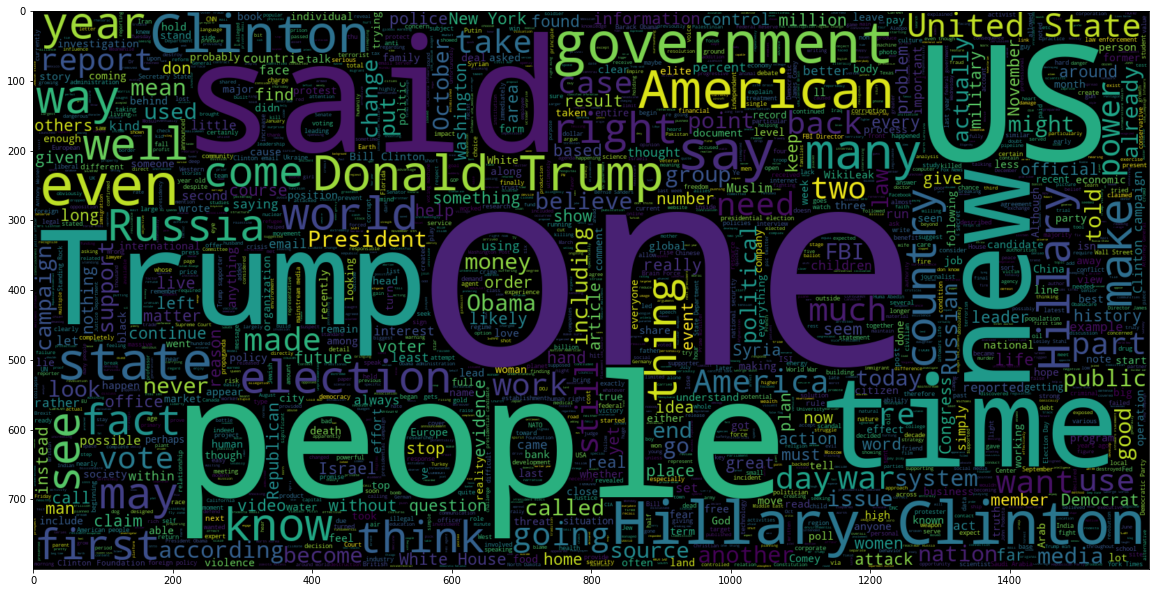

In [17]:
# word clouds for fake news
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc, interpolation = 'bilinear')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


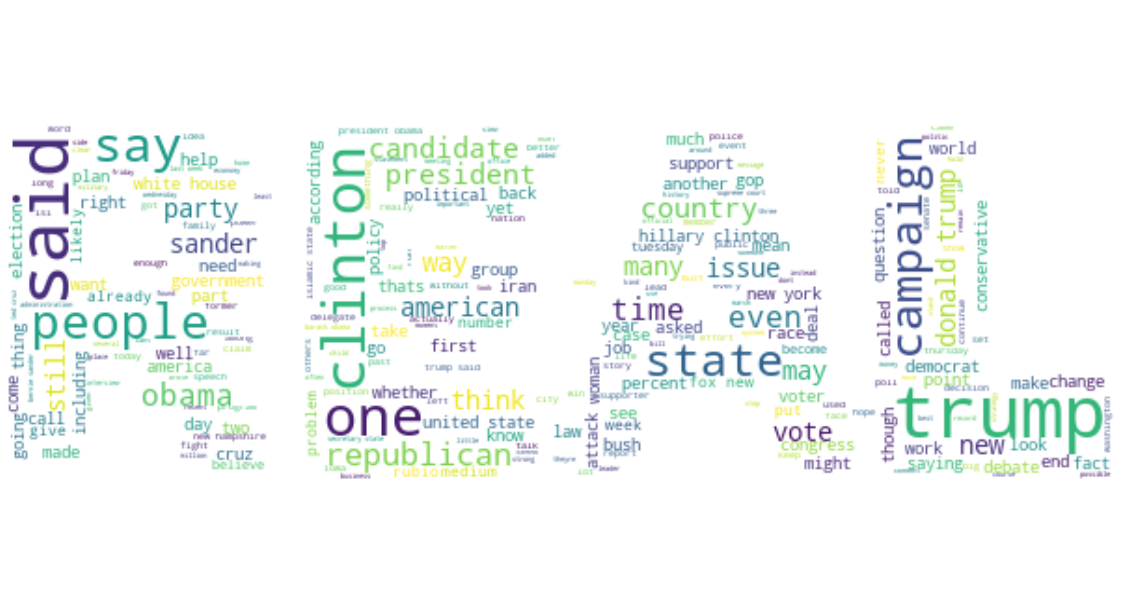

<Figure size 432x288 with 0 Axes>

In [18]:
nltk.download('wordnet')
plt.figure(figsize = (20,20))
def clean(text: str) -> list:
  'A simple function to cleanup text data'
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (text.encode('ascii', 'ignore')
           .decode('utf-8', 'ignore')
           .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

corpus = clean(' '.join(df[df.label == 1].text))

def listToString(s):
  str1 = " "
  return (str1.join(s))

corpus_str = listToString(corpus)
#d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
def transform_format(val):
  if val.any() == 0:
    return 255
  else:
    return val

#coloring = np.array(Image.open(path.join(d, "/content/gdrive/MyDrive/Daco_115064.png")))
coloring = np.array(Image.open("/content/gdrive/MyDrive/REAL_Word_Mark_Green_Logo.jpg"))

stoplist = set(STOPWORDS)
wc = WordCloud(background_color = "white", max_words = 2000, width = 1600, height = 800,mask = coloring, stopwords = stoplist, max_font_size = 100)

wc.generate(corpus_str)

image_colors = ImageColorGenerator(coloring)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("real_new_word_cloud.png", bbox_inches = 'tight', dpi = 600)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


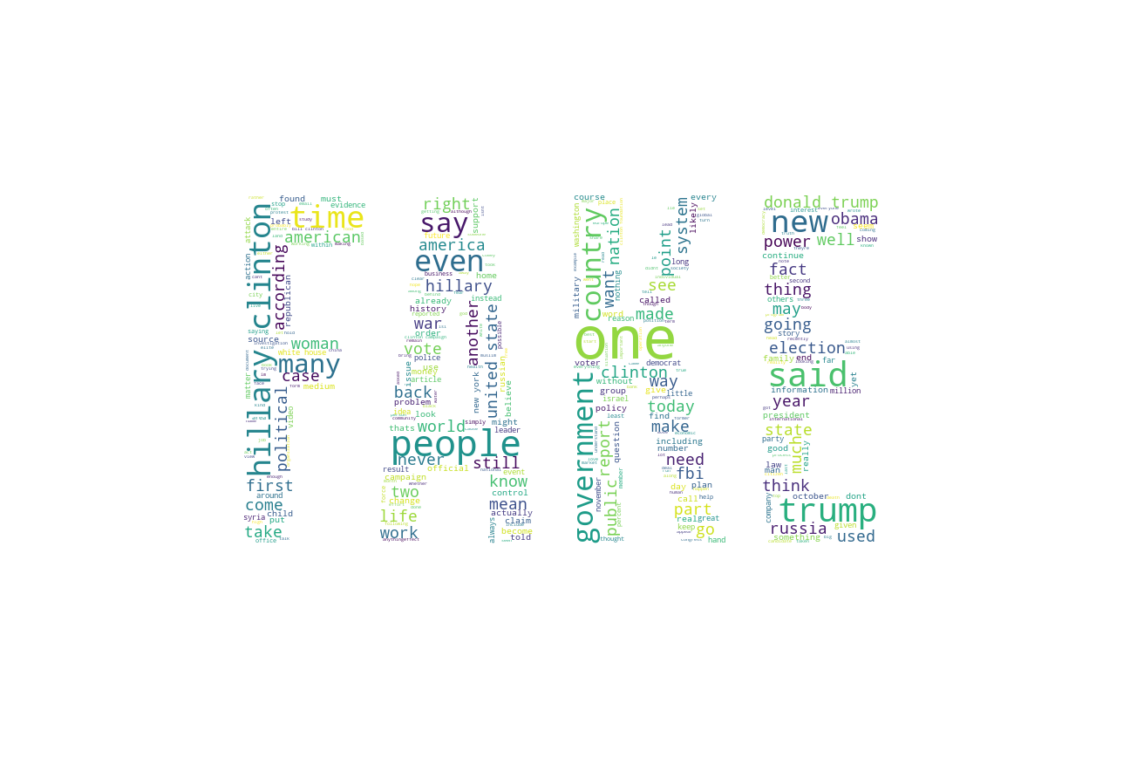

<Figure size 432x288 with 0 Axes>

In [19]:
nltk.download('wordnet')
plt.figure(figsize = (20,20))
def clean(text: str) -> list:
  'A simple function to cleanup text data'
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (text.encode('ascii', 'ignore')
           .decode('utf-8', 'ignore')
           .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

corpus = clean(' '.join(df[df.label == 0].text))

def listToString(s):
  str1 = " "
  return (str1.join(s))

corpus_str = listToString(corpus)
#d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
def transform_format(val):
  if val.any() == 0:
    return 255
  else:
    return val

#coloring = np.array(Image.open(path.join(d, "/content/gdrive/MyDrive/Daco_115064.png")))
coloring = np.array(Image.open("/content/gdrive/MyDrive/tumblr_mkfgk4gtzO1qajmbto1_1280.jpg"))

stoplist = set(STOPWORDS)
wc = WordCloud(background_color = "white", max_words = 2000, width = 1600, height = 800,mask = coloring, stopwords = stoplist, max_font_size = 100)

wc.generate(corpus_str)

image_colors = ImageColorGenerator(coloring)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("real_new_word_cloud.png", bbox_inches = 'tight', dpi = 600)



Word Embedding using BERT

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'], stratify = df['label'])

In [21]:
max_len =  128
train_batch_size = 16
valid_batch_size = 16
epochs = 3
learning_rate = 1e-5
filters = 50
filter_sizes = [2, 3 ,4 ,5]
hidden_size = 768
dropout = 0.1


In [22]:
from transformers import BertTokenizer, BertModel, BertConfig


In [23]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
x_train_tokens = tokenizer.batch_encode_plus(
    x_train.tolist(),
    add_special_tokens = True,
    max_length = max_len,
    padding = 'max_length',
    truncation = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

x_test_tokens = tokenizer.batch_encode_plus(
    x_test.tolist(),
    add_special_tokens = True,
    max_length = max_len,
    padding = 'max_length',
    truncation = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [25]:
x_train_tokens, x_test_tokens

({'input_ids': tensor([[  101,  6529,  4366,  ...,  9029, 29536,   102],
         [  101,  8112,  2758,  ...,  5815,  4122,   102],
         [  101,  7207, 22028,  ...,     0,     0,     0],
         ...,
         [  101,  4952,  6221,  ...,  7816,  1010,   102],
         [  101,  2503,  8879,  ...,  6481,  4025,   102],
         [  101, 25297, 29324,  ...,  2038,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]])},
 {'input_ids': tensor([[  101,  2274, 10275,  ...,  1012,  2196,   102],
         [  101,  2303,  3033,  ...,     0,     0,     0

In [26]:
y_train_2d = [[x] for x in y_train.tolist()]
y_test_2d = [[x] for x in y_test.tolist()]

y_train_tensor = torch.tensor(y_train_2d)
y_test_tensor = torch.tensor(y_test_2d)

In [27]:
#DataLoaders -> data become iteral
batch_size = 16

train_data = TensorDataset(x_train_tokens['input_ids'], x_train_tokens['token_type_ids'], x_train_tokens['attention_mask'], y_train_tensor)
train_data_sampler = RandomSampler(train_data)
train_data_loader = DataLoader(train_data, sampler = train_data_sampler, batch_size = batch_size)

test_data = TensorDataset(x_test_tokens['input_ids'], x_test_tokens['token_type_ids'], x_test_tokens['attention_mask'], y_test_tensor)
test_data_sampler = RandomSampler(test_data)
test_data_loader = DataLoader(test_data, sampler = test_data_sampler, batch_size = batch_size)



In [28]:
 
class bert_cnn_model(nn.Module):
  def __init__(self, model):
    super(bert_cnn_model, self).__init__()
    model_config = BertConfig.from_pretrained('bert-base-uncased', return_dict = False, output_hidden_states=True)
    self.bert = BertModel.from_pretrained('bert-base-uncased', config = model_config)
    for param in self.bert.parameters():
      param.requires_grad = True #update data
    self.convs = nn.ModuleList([nn.Conv1d(1, filters, (k, hidden_size)) for k in filter_sizes])
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(filters * len(filter_sizes), 2)

  def conv_and_pool(self, x, conv):
    x = conv(x) #[batch_size,channel_num,pad_size,embedding_size（1）]
    x = nn.ReLU(x) 
    x = x.squeeze(3) #[batch_size,channel_num,pad_size]
    x = nn.MaxPool1d(x, x.size(2))
    x = x.squeeze(2) # [batch_size,channel_num]
    return x

  def forward(self, x):
    context = x[0]
    mask = x[2]

    encoder_out, pooled = self.bert(context, attention_mask = mask, output_all_encoded_layers=False)
    out = torch.cat([self.conv_and_pool(encoder_out,conv) for conv in self.convs],1)
    out = self.fc(out)
    return out
    

In [ ]:
#model = BertModel.from_pretrained('bert-base-uncased', return_dict = False, output_hidden_​​states = True)

In [29]:
bc_model = bert_cnn_model(nn.Module)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
bc_model.to(device)

In [32]:
#loss function
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)

cross_entropy = nn.NLLLoss(weight = weights)


In [33]:
class_weights

array([0.99833222, 1.00167336])

In [34]:
#optimizer
optimizer = torch.optim.Adam(params = bc_model.parameters(), lr = learning_rate)


In [36]:
#Train model

def train_model(
    n_epochs,
    training_loader,
    validation_loader,
    model, 
    optimizer
  ):

  valid_loss_min = np.Inf

  for epoch in range(1, n_epochs + 1):
      print("Epoch {:} / {:}".format(epoch, epochs))
      train_loss, valid_loss = 0, 0
      avg_train_accuracy, avg_valid_accuracy = 0, 0
      accuracy = 0
      model.train()
      train_predictions = []
      valid_predictions = []

      #training loop
      for idx, batch in enumerate(training_loader):
          batch = [r.to(device) for r in batch]
          input_ids, attention_masks, labels = batch
          outputs = model(batch)
          model.zero_grad()  #clear previously calculated gradients
          optimizer.zero_grad()
          loss = cross_entropy(outputs, labels.squeeze(1))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss = train_loss + (1/(idx + 1) * (loss.item() - train_loss))
          outs = outputs.detach().cpu().numpy()
          train_predictions.append(outs)
          predictions = torch.argmax(outputs, dim = 1)
          accuracy += sum([1 if predictions[i] == labels[i] else 0 for i in range(len(labels))])
          
      avg_train_accuracy = accuracy / len(training_loader.dataset)
      print(f'\Training Accuracy: {avg_train_accuracy}')
      print(f'\Training Loss: {train_loss: .f}')

      #validation loop
      accuracy = 0
      model.eval()
      with torch.no_grad():
        for idx, bacth in enumerate(validation_loader):
            batch = [r.to(device) for r in batch]
            input_ids, attention_masks, labels = batch
            outputs = model(batch)
            loss = cross_entropy(outputs, labels.squeeze(1))
            valid_loss = valid_loss + (1/(idx + 1) * (loss.item() - valid_loss))
            outs = outputs.detach().cpu().numpy()
            valid_predictions.append(outs)
            predictions = torch.argmax(outputs, dim = 1)
            accuracy += sum([1 if predictions[i] == labels[i] else 0 for i in range(len(labels))])
            
      if valid_loss < valid_loss_min:
          valid_loss_min = valid_loss
          torch.save(model.state_dict(), 'saved_wrights.pt')

      avg_valid_accuracy = accuracy / len(validation_loader.dataset)
      print(f'\Validation Accuracy: {avg_valid_accuracy}')
      print(f'\Validation Loss: {valid_loss: .f}')
      #print(f'roc_auc score: {roc_auc_score(y_train_tensor, train_predictions)}')
      #print(f'F1 score: {f1_score(y_train_tensor, train_predictions)}')

  return bert_model
  


In [81]:
train_model = train_model(epochs, train_data_loader, test_data_loader, bc_model, optimizer)